# Telepromter adatok elemzése - 3. Házi Data Science Verseny - Jákob Tamás

### 0.2 Importok

In [1]:
#!pip install plotnine
#!pip install pyarrow
#!pip install lxml
#pip install pycaret
#!pip install networkx
#!pip install ipywidgets
#!pip install umap-learn

In [2]:
from plotnine import (ggplot, aes, geom_histogram, geom_path, theme_minimal, 
                    labs, annotate, geom_point, geom_smooth, scale_fill_manual, geom_bar, 
                    coord_flip, theme,element_text, geom_text, position_stack, geom_line,
                    ylim, scale_fill_brewer, geom_col, scale_fill_gradient, geom_vline, geom_hline)
import numpy as np
import polars as pl
import pandas as pd
import pyarrow
from pycaret.classification import *
from pycaret.clustering import *
import umap
from scipy.stats import mannwhitneyu
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import plotly
import plotly.io as pio
pio.renderers.default = "iframe"

pd.set_option('display.max_rows', 101)
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)

np.random.seed(42)

## 5. Felhasználói viselkedések elemzése

## 5.1 Felhasználói viselkedések vizualizálása

A nagyon sok féle (700+ darab) esemény miatt az eseményeket csoportosítottam. Az ugyanahhoz a felhasználói kattintáshoz/gombhoz/funkcióhoz tartozó események kerültek hozzárendelésre group oszlopban lévő részcsoportokra nevekre:


![groups](./images/groups.png)

Az eventek leírása a "TP_event_descriptions.csv" fájlban kerültek átadásra.

In [6]:
event_descriptions = pl.read_csv("TP_event_descriptions.csv", separator=";").lazy()
filtered_df = pl.scan_parquet("data/filtered_df.parquet")

A "main_events" változóban a user-flow fő állomásaihoz tartozó ún. fő események kerültek eltárolásra.

In [7]:
#del df_pivoted
main_events = ["billing_issue_event", "cancellation_event", 
              "expiration_event", "initial_purchase_event", 
              "product_change_event", "renewal_event","trial_cancelled_event",
              "trial_converted_event","trial_started_event","uncancellation_event",
              ]

full_filtered_df = filtered_df.join(event_descriptions, on = "event").drop("event_description")
full_filtered_df.collect().write_parquet("data/full_filtered_df.parquet")
event_descriptions.collect()
#full_filtered_df.collect()

groups,event,event_description
str,str,str
"""$ae""","""$ae_first_open""","""Triggered the first time a use…"
"""$ae""","""$ae_iap""","""Triggered when an in-app purch…"
"""$ae""","""$ae_session""","""Indicates the start or continu…"
"""$ae""","""$ae_updated""","""Likely fired when the app or u…"
"""$create_alias""","""$create_alias""","""Analytics event merging/aliasi…"
…,…,…
"""Word""","""WordEditViewController.selecte…","""A specific word was selected f…"
"""Word""","""WordEditViewController.styleEd…","""User enabled style editing mod…"
"""Word""","""WordEditViewController.timeEdi…","""User enabled time editing mode…"


Meghatározom, hogy az eventek mely fő eventek közé esnek.

In [7]:
del filtered_df
def sort_flag_shift_a_df(full_filtered_df, main_events):
    '''
    A függvény sorbarendezi az adatokat először felhasználók majd az az események ideje szerint.
    A start_flag megmutatja, hogy az adott event az adott usernél hanyadik main event része.
    Az adatok event oszlopát eltolom -1-el az "end_event" oszlopba, hogy meglegyen az átmenet, majd létrehozom a "transition" oszlopot ami az adott
    sorhoz tartozó event átmenetet tartalmazza.
    
    full_filtered_df:
        Az eseményeket tartalmazó dataframe.
    main_events:
        A kiemelt események, amikre szűrni fog a függvény.
        
    '''
    df_sorted = full_filtered_df.sort(["distinct_id", "seconds"])
    df_flagged = (
        df_sorted
        .with_columns([
            # új oszlop: 1, ha event == "start", különben 0
            (pl.col("event").is_in(main_events)).cast(pl.Int8).alias("start_flag"),
    
        ])
        .with_columns([
            # számoljuk össze, hányadik "start" eseménynél vagyunk: ez lesz a session_id
            pl.col("start_flag").cum_sum().alias("session_id")
        ])
    )
    
    df_shifted = (
        df_flagged.with_columns([
            pl.col("event").shift(-1).alias("end_event")
        ]
        )
    )
    df_shifted2 = (
        df_shifted.with_columns([
            (pl.col("event").first() + " -> " +pl.col("end_event").last()).over("session_id").alias("transition")
        ])
    )
    return df_shifted2
df_shifted2 = sort_flag_shift_a_df(full_filtered_df, main_events)

df_shifted2.collect().head(3)


event,distinct_id,os_version,country_code,date,time_since_first_event,days,hours,minutes,seconds,groups,start_flag,session_id,end_event,transition
str,str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32,str,i8,i64,str,str
"""secondOrMoreOpening""","""$RCAnonymousID:user_0070011269…","""18.1.1""","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""Second""",0,0,"""device_attributes""","""secondOrMoreOpening -> trial_s…"
"""device_attributes""","""$RCAnonymousID:user_0070011269…","""18.1.1""","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""device_attributes""",0,0,"""config_attributes""","""secondOrMoreOpening -> trial_s…"
"""config_attributes""","""$RCAnonymousID:user_0070011269…","""18.1.1""","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""config_attributes""",0,0,"""user_attributes""","""secondOrMoreOpening -> trial_s…"


Leszűröm az adatokat fő eseményekre és mellék eseményekre:

In [8]:
#df_side_events = df_shifted2.filter(~pl.col("event").is_in(main_events))
df_main_events = df_shifted2.filter(pl.col("event").is_in(main_events)).drop_nans().drop_nulls().sort("distinct_id", "seconds").collect()
#df_main_events.head(5)
del df_shifted2

A df_count fogja tartalmazni az átmenetek aggregált értékeit. A "len_normalised" oszlop vizualizációt segítő segéd oszlop.

In [9]:
df_count = df_main_events.group_by("transition").len().drop_nans().sort("transition")
df_count = df_count.with_columns([
    pl.col("len").log().alias("lenlog")
])
df_count = df_count.with_columns([
    ((pl.col("lenlog") - pl.col("lenlog").min()) / (pl.col("lenlog").max() - pl.col("lenlog").min()))
    .alias("len_normalised")
]).drop("lenlog")
del df_main_events
df_count.to_pandas().head(10)

,transition,len,len_normalised
0,billing_issue_event -> billing_issue_event,7,0.203992
1,billing_issue_event -> cancellation_event,39,0.384056
2,billing_issue_event -> expiration_event,547,0.660903
3,billing_issue_event -> renewal_event,5,0.168719
4,billing_issue_event -> trial_cancelled_event,1336,0.754516
5,billing_issue_event -> trial_converted_event,12,0.260496
6,billing_issue_event -> trial_started_event,708,0.687949
7,cancellation_event -> billing_issue_event,8,0.217990
8,cancellation_event -> cancellation_event,2,0.072663
9,cancellation_event -> expiration_event,131,0.511073


A main event átmenetek mátrix formában:

In [10]:
df_count_matrix = df_count.with_columns([
    pl.col("transition").str.split(" -> ").alias("parts")
]).with_columns([
    pl.col("parts").list.get(0).str.replace(r"_event$", "", literal=False).alias("source"),
    pl.col("parts").list.get(1).str.replace(r"_event$", "", literal=False).alias("target")
]).drop("parts").pivot(
    values="len",
    index="source",
    columns="target",
    aggregate_function="first"
).fill_null(0)

df_count_matrix

source,billing_issue,cancellation,expiration,renewal,trial_cancelled,trial_converted,trial_started,product_change,uncancellation,initial_purchase
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""billing_issue""",7,39,547,5,1336,12,708,0,0,0
"""cancellation""",8,2,131,12,1,3,885,2,25,0
"""expiration""",239,66,5,10,555,262,11727,0,0,5
"""initial_purchase""",0,3,0,0,0,0,2,0,0,0
"""product_change""",5,57,2,49,21,39,39,0,7,0
"""renewal""",6,30,2,75,0,0,51,11,0,0
"""trial_cancelled""",1329,39,11696,2,17,20,2604,13,649,0
"""trial_converted""",105,810,14,20,287,56,2020,135,0,0
"""trial_started""",961,4,494,0,13893,2779,4,48,0,0


Következtetések levonása:
- A legnagyobb "bottleneck" esemény a billing issue event
- Fizetési nehézségeknél azonnal otthagyják a felhasználók az alkalmazást, és többet nem próbálják meg
- Szinte minden fő eseményből vezet út a billing_issue felé, ami állandó lemorzsolódási veszély

Az átmetek ábrázolása gráfon

In [11]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np


# Gráf létrehozása
G = nx.DiGraph()

# Átmenetek hozzáadása élként, súllyal
for row in df_count.iter_rows():
    src, dst = row[0].split(" -> ")
    src = src.split("_event")[0]
    dst = dst.split("_event")[0]
    count = df_count.filter(pl.col("transition") == row[0]).select("len").item()
    
    G.add_edge(src, dst, weight=count, normalised=row[-1])

pos = nx.circular_layout(G)
cmap = mcolors.LinearSegmentedColormap.from_list("orange_to_green", ["green", "orange"])

# Bézier görbe koordináták generálása
def curved_edge(x0, y0, x1, y1, curvature=0.2):
    mx, my = (x0 + x1) / 2, (y0 + y1) / 2
    dx, dy = x1 - x0, y1 - y0
    nx_ = -dy 
    ny_ = dx
    norm = np.sqrt(nx_ ** 2 + ny_ ** 2)
    if norm == 0:
        return [x0, x1, None], [y0, y1, None], (mx, my)
    nx_ /= norm
    ny_ /= norm
    cx, cy = mx + curvature * nx_, my + curvature * ny_

    t = np.linspace(0, 1, 20)
    bez_x = (1 - t) ** 2 * x0 + 2 * (1 - t) * t * cx + t ** 2 * x1
    bez_y = (1 - t) ** 2 * y0 + 2 * (1 - t) * t * cy + t ** 2 * y1

    mid_idx = len(t) // 2
    label_pos = (bez_x[mid_idx], bez_y[mid_idx])
    return list(bez_x) + [None], list(bez_y) + [None], label_pos

def gen_line_width(weight):
    if weight > 10000:
        return 2
    if weight > 500:
        return 1
    return 0.5

# Élek és feliratok gyűjtése
edge_x = []
edge_y = []
label_x = []
label_y = []
label_text = []
edges = []
seen_edges = set()
label_hover_text = []

for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]

    if (v, u) in G.edges() and (v, u) not in seen_edges:
        curved_x, curved_y, (lx, ly) = curved_edge(x0, y0, x1, y1, curvature=0.3)
    else:
        curved_x, curved_y, (lx, ly) = [x0, x1, None], [y0, y1, None], ((x0 + x1)/2, (y0 + y1)/2)
    w = data["normalised"]
    edge_color = mcolors.to_hex(cmap(w))
    edge_x += curved_x
    edge_y += curved_y
    label_x.append(lx)
    label_y.append(ly)
    label_text.append(data.get("weight", f"{u}→{v}"))
    label_hover_text.append(f"{u}→{v}:{data.get('weight', '')}")
    seen_edges.add((u, v)) 
    edge = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode='lines',
        line=dict(width=gen_line_width(data["weight"]), color='gray'),
        hoverinfo='none',
    )
    edges.append(edge)

# Él rajzolása
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
)

# Él szövegek (középen, kicsit eltolva)
label_trace = go.Scatter(
    x=label_x,
    y=label_y,
    mode='text',
    text=label_text,
    textposition='top center',
    hoverinfo = 'text',
    hovertext=label_hover_text,
    textfont=dict(color='black', size=14)
)

# Csúcsok
node_x = []
node_y = []
node_labels = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_labels.append(node)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,
    textposition='bottom center',
    marker=dict(size=25, color='lightblue', line=dict(width=2, color='blue')),
    hoverinfo='text'
)

# Ábra összeállítása
fig = go.Figure(data=edges+[ label_trace, node_trace] ,
                layout=go.Layout(
                    title="Felhasználói kulcs események átmenetei",
                    showlegend=False,
                    hovermode='closest',
                    width=800, height=800,
                    margin=dict(b=20, l=5, r=5, t=60),
                    xaxis=dict(showgrid=False, zeroline=False, visible= False),
                    yaxis=dict(showgrid=False, zeroline=False, visible = False),
                    paper_bgcolor='white',
                    plot_bgcolor='white',
                ))

fig.show()

NameError: name 'mcolors' is not defined

## A billing issue esemény vizsgálataországos lebontásban
Van-t területi függés a fizetési nehézségek esetében, azaz érdemes valamelyik ország felhasználóinál kiemelt figyelmet fordítani a fizetési rendszer monitorozására?

In [12]:
######### TODO: billing issue - > ország diagramm

## 5.2 Felhasználói események vizsgálata a trial kezdete és vége között

A felhasználókat 2 csoportba osztom "trial_started_event -> trial_converted_event" illetve "trial_started_event -> trial_cancelled_event" event szerint. A korábbi key_events alapú szűrést lecsökkentem erre a 3 eseményre, hogy pl. lássuk például hogyan használja az appot a felhasználó bulling_issue_event után is.

In [13]:
trial_events_for_analysis = ["trial_cancelled_event",
              "trial_converted_event","trial_started_event"
              ]
trial_transitions = ["trial_started_event -> trial_cancelled_event", "trial_started_event -> trial_converted_event"]

df_trial = sort_flag_shift_a_df(full_filtered_df, trial_events_for_analysis)
df_trial_filtered = df_trial.filter(pl.col("transition").is_in(trial_transitions)).drop_nans().drop_nulls().sort("distinct_id", "seconds")
#df_trial_filtered.collect()

Az adatcsomagot leszűröm azokra a felhasználókra, akik nem csak feltelepítették az alkalmazást. A cél, hogy olyan a felhasználókat és videlkedésüket tudjam összehasonlítani, akik használták az appot, és az alapján döntöttek.
A szűrést az egynél több "Homescreen" esemény meglétével fogom végezni. Ez lesz a minimum kritérium annak eldöntésére, hogy a felhasználó leglább az alap funkciókat kipróbálta az alkalmazásban.

In [14]:
df_trial_agg_for_filter = df_trial.filter(
    pl.col("groups") == "Homescreen"
).group_by("distinct_id").agg(pl.col("groups").count()).filter(pl.col("groups") > 1).collect()
df_trial_users_homescreen = df_trial_agg_for_filter["distinct_id"].to_list()
print(f"A felhasználók száma, akik több, mint egyszer jutottak el a Homescreen-re: {len(df_trial_users_homescreen)}")

A felhasználók száma, akik több, mint egyszer jutottak el a Homescreen-re: 14759


In [15]:
print(df_trial_filtered.collect().shape)
df_trial_filtered = df_trial_filtered.filter(pl.col("distinct_id").is_in(df_trial_users_homescreen))
df_trial_filtered.collect()

(2171679, 15)


event,distinct_id,os_version,country_code,date,time_since_first_event,days,hours,minutes,seconds,groups,start_flag,session_id,end_event,transition
str,str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32,str,i8,i64,str,str
"""trial_started_event""","""$RCAnonymousID:user_0092548370…","""18.3""","""GB""",2025-02-11 02:11:57,3h 38m 23s,0,3,218,13103,"""trial_started_event""",1,3,"""app_close""","""trial_started_event -> trial_c…"
"""app_close""","""$RCAnonymousID:user_0092548370…","""18.3""","""GB""",2025-02-11 02:12:00,3h 38m 26s,0,3,218,13106,"""app""",0,3,"""app_open""","""trial_started_event -> trial_c…"
"""app_open""","""$RCAnonymousID:user_0092548370…","""18.3""","""GB""",2025-02-11 02:12:07,3h 38m 33s,0,3,218,13113,"""app""",0,3,"""$ae_iap""","""trial_started_event -> trial_c…"
"""$ae_iap""","""$RCAnonymousID:user_0092548370…","""18.3""","""GB""",2025-02-11 02:12:07,3h 38m 33s,0,3,218,13113,"""$ae""",0,3,"""purchasesuccess""","""trial_started_event -> trial_c…"
"""purchasesuccess""","""$RCAnonymousID:user_0092548370…","""18.3""","""GB""",2025-02-11 02:12:08,3h 38m 34s,0,3,218,13114,"""purchase""",0,3,"""ThankYouScreen""","""trial_started_event -> trial_c…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""VideoPreviewScreen.exportVideo""","""user_99947267453523""","""17.5.1""","""ID""",2025-01-23 19:18:52,20m 45s,0,0,20,1245,"""VideoPreview""",0,38163,"""VideoPreviewScreen.SaveSuccess""","""trial_started_event -> trial_c…"
"""VideoPreviewScreen.SaveSuccess""","""user_99947267453523""","""17.5.1""","""ID""",2025-01-23 19:18:52,20m 45s,0,0,20,1245,"""VideoPreviewScreen.SaveSuccess""",0,38163,"""RatingPromptShownImmediately""","""trial_started_event -> trial_c…"
"""RatingPromptShownImmediately""","""user_99947267453523""","""17.5.1""","""ID""",2025-01-23 19:18:52,20m 45s,0,0,20,1245,"""Rating""",0,38163,"""$ae_session""","""trial_started_event -> trial_c…"


A későbbi eredmények alapján a nem hasznos események szűrése:

In [16]:
minor_event_to_drop = ["user", "session", "Show", "$identify", "session",
                      "Second", "identity_alias", "user",
                       "Thank", "$create_alias", "hideReviewTap", "Homescreen", "proUserSignIn",
                       "$ae", "device_attributes", "config_attributes", "Tele", "branch", "Rating",
                       "update", "app", "Regist", "Login", "expiration_event", "NoRatingBecauseOfNoSceneError",
                       "SettingsScreen", "Whats", "reviewTap", "purchase", "checkSubscriptionStatus.Error",
                       "fetchRedeemedPromoCodea.Error", "bluetooth", "open", "paywall", "Welcome",
                       "chooseFacebook", "chooseYoutube", "subscription", "Word", "OpenScript", "SortingTap",
                       "script", "Editorscreen", "create", "Record", "deleteRecording", "Folder",
                       "TeleprompterDidLoaded", "remove", "PlayerScreen", "product_change_event",
                       "start", "stop", "add", "billing_issue_event", "Font", "Selected", "TrialScreenCloseTap",
                       "caption", "subtitle", "userDidTakeScreenshotNotification", "deeplinkRemoteConnectUsed",
                       "TrialScreenPurchaseSuccess", "documentPicker.Error", "did_receive_asa_attribution", "setup",
                       "connect", "Select", "assigned", "cancellation_event", "handle", "getPreviousTranscriptionJob.Error",
                       "Settings", "Manage", "SelectPlatform", "ShowRegistrationFromSettings", "TrialScreenCloseConfirmation",
                       "WCSession*ERROR", "trial_started_event", "errorCatched", "didRegister", "AudioCleaningError"
                      ]



In [18]:
df_trial_filtered = df_trial_filtered.filter(~pl.col("groups").is_in(minor_event_to_drop))
df_trial_filtered.collect().write_parquet("./data/df_trial_filtered.parquet")

A következő függvényben a "pl.col("country_code").mode().first()" sorban a mode() azért került bele, mert egyes felhasználók több országból is használták az alkalmazást. A mode segítségével a leggyakrabb helyről történő bejelentkezés lett hozzárendelve az adott felhasználóhoz.

In [16]:
def aggregate_and_pivot_users(df):
    '''
    A függvény először aggregálja a teljes adatcsomagot az események száma és első előfordulási ideje szerint, 
    majd pivot táblát készít belőle, hogy a long formátum helyett wide formátum legyen a kimenet.
    '''
    df_agg = (
        df.group_by(["distinct_id", "groups"])
        .agg([
            pl.col("seconds").count().alias("event_count"),
            pl.col("seconds").min().alias("first_event_time"),
            pl.col("transition").first(),
            pl.col("country_code").mode().first()
            
        ])
    ).collect()
    pivot_df = df_agg.pivot(values=["event_count", "first_event_time" ], 
                         index=["distinct_id", "transition", "country_code"], 
                         columns="groups").fill_null(0)
    #pivot_df = pivot_df.drop('distinct_id')
    return pivot_df

In [17]:
aggregated_and_pivoted_users_df_with_transitions = aggregate_and_pivot_users(df_trial_filtered)
aggregated_and_pivoted_users_df_with_transitions.write_parquet("./data/aggregated_and_pivoted_users_df_with_transitions.parquet")
aggregated_and_pivoted_users_df_with_transitions.to_pandas()

,distinct_id,transition,country_code,event_count_RecordViewController.startSpeechRecognizing,event_count_SetLexendFont,event_count_VideoPreview,event_count_VideoPreviewScreen.SaveSuccess,event_count_Visual,event_count_SetOpenDyslexicFont,event_count_Replace,event_count_AI,event_count_ScriptGeneratorScreen,event_count_trigger_fire,event_count_Practice,event_count_Live,event_count_purchase_abandoned,event_count_Intercom,event_count_blur,event_count_capture,event_count_PlayerViewControllerSpeechRecognizing,event_count_ShowReferralScreen,event_count_Trim,event_count_LiveTutorial,event_count_SubtitleStyleSelectorViewController.styleSelected,event_count_Margin,event_count_Resize,event_count_LiveURL,event_count_Video,event_count_ConnectAccount,event_count_save,event_count_Remote,event_count_AppStorePromoPurchase,event_count_Onboarding,event_count_account,event_count_Web,event_count_FBApp,event_count_SignOut,event_count_Shortcut,event_count_New,event_count_Preview,event_count_first_seen,event_count_PlainTextExport,event_count_send,event_count_freeTrial_start,event_count_Rephrase,event_count_reset,event_count_transaction_complete,event_count_Copied,event_count_sourceSelected,event_count_LiveStreamLink,...,first_event_time_LiveTutorial,first_event_time_SubtitleStyleSelectorViewController.styleSelected,first_event_time_Margin,first_event_time_Resize,first_event_time_LiveURL,first_event_time_Video,first_event_time_ConnectAccount,first_event_time_save,first_event_time_Remote,first_event_time_AppStorePromoPurchase,first_event_time_Onboarding,first_event_time_account,first_event_time_Web,first_event_time_FBApp,first_event_time_SignOut,first_event_time_Shortcut,first_event_time_New,first_event_time_Preview,first_event_time_first_seen,first_event_time_PlainTextExport,first_event_time_send,first_event_time_freeTrial_start,first_event_time_Rephrase,first_event_time_reset,first_event_time_transaction_complete,first_event_time_Copied,first_event_time_sourceSelected,first_event_time_LiveStreamLink,first_event_time_ShowRemoteEdit,first_event_time_type,first_event_time_setNew,first_event_time_Could,first_event_time_GameControllerManager.Connected,first_event_time_bionic,first_event_time_ConnectYouTube,first_event_time_Kids,first_event_time_RecordScreen4KTap,first_event_time_ShowTrialExtensionImmediately,first_event_time_Mirroring,first_event_time_ConnectFacebook,first_event_time_TrialScreenSubscribeTap,first_event_time_TrialExtensionScreen,first_event_time_transaction_start,first_event_time_Core,first_event_time_PastedSpeedAndFontsize,first_event_time_ShowRegistrationFromProfileSettings,first_event_time_cancel,first_event_time_import,first_event_time_FootPedalRemoteScreen,first_event_time_PresentationRemoteScreen
0,$device:user_96942424519892,trial_started_event -> trial_cancelled_event,MY,4,0,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,12542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,$device:user_95911833057093,trial_started_event -> trial_cancelled_event,LK,0,1,0,0,1,1,0,3,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,$device:user_82802896064407,trial_started_event -> trial_cancelled_event,UA,0,0,60,8,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,310,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,$device:user_27126147984333,trial_started_event -> trial_cancelled_event,ID,0,0,14,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,$device:user_29601701459716,trial_started_event -> trial_cancelled_event,BG,0,0,161,12,1,0,5,0,0,0,0,0,0,0,3,2,0,0,20,0,12,0,0,0,0,0,0,0,0,

In [18]:
cancelled_users_df = aggregated_and_pivoted_users_df_with_transitions.filter(pl.col("transition") == trial_transitions[0])
converted_users_df = aggregated_and_pivoted_users_df_with_transitions.filter(pl.col("transition") == trial_transitions[1])
print(f"cancelled_users_df shape: {cancelled_users_df.shape}")
print(f"converted_users_df shape: {converted_users_df.shape}")

cancelled_users_df shape: (10953, 141)
converted_users_df shape: (2017, 141)


Végezzünk statisztikai hipotézis vizsgálatot a két célcsoport által produkált eseményekre.

**H0**: A két célcsoport egyes eseményei között **nincs signifikáns különbség**.

**H1**: A két célcsoport egyes eseményei között **van signifikáns különbség**.

Ennek eldöntésére a Mann–Whitney U-tesztet fogom elvégezni, mivel az adatok nem normál eloszlásúak.

In [19]:
def MW_U_teszt(list1, list2):
    stat, p_value = mannwhitneyu(list1, list2, alternative='two-sided')
    return stat, p_value

def MW_U_teszt_for_all_columns(df_cancelled, df_converted):
    '''
    Mann–Whitney U-tesztet végez 2 lista értékei között.
    list1, list2:
        Bemeneti listák amiket összehasonlítunk. Ezek a listák 1-1 eventet jelölnek.
    result:
        Visszatérési érték dictionary formában. A kulcs az adott esemény neve, az érték pedig (p érték, U-statiszkika) formában tárolódik.
    '''
    cols = df_cancelled.columns
    cols = cols[3:]
    result = {}
    for col in cols:
        list1 = df_cancelled[col].to_list()
        list2 = df_converted[col].to_list()
        stat, p_value = MW_U_teszt(list1, list2)
        result[col] = [p_value, stat]   
    return result

In [20]:
results = MW_U_teszt_for_all_columns(cancelled_users_df, converted_users_df)

In [21]:
results_df = pl.DataFrame(results).transpose(include_header=True)
results_df.columns = ["event group", "p-value", "U-statistic"]
results_df = results_df.sort("p-value")

Kiszámolom a "neg_log" értéket, ami a p-érték logaritmusának mínusz egy szerese. A vizulalizálás során lesz felhasználva.

In [22]:
results_df2 = results_df.with_columns([
    ((pl.col("p-value").log())*(-1)).alias("neg_log")
]).sort("neg_log", descending=True).to_pandas()
results_df2["event group"] = pd.Categorical(results_df2["event group"], categories=results_df2["event group"].unique()[::-1].tolist(), ordered=True)

filtered_first_event_time = results_df2[results_df2["event group"].str.startswith("first_event_time")]
filtered_event_count = results_df2[results_df2["event group"].str.startswith("event_count")]
results_df2.head(74)

,event group,p-value,U-statistic,neg_log
0,event_count_VideoPreview,3.752687e-21,9591044.0,47.031815
1,first_event_time_SetOpenDyslexicFont,3.671753e-20,10303673.0,44.751033
2,first_event_time_SubtitleStyleSelectorViewCont...,2.437166e-19,10420919.5,42.858281
3,event_count_SubtitleStyleSelectorViewControlle...,3.166903e-19,10423000.0,42.596363
4,event_count_SetOpenDyslexicFont,3.879811e-19,10324730.5,42.393330
5,event_count_first_seen,6.068822e-19,10692489.0,41.945952
6,first_event_time_first_seen,6.162347e-19,10692532.5,41.930659
7,first_event_time_Onboarding,2.179143e-15,10733294.5,33.759845
8,event_count_Onboarding,2.449703e-15,10733884.0,33.642810
9,first_event_time_Live,2.129295e-14,10571059.5,31.480400


Az események jelentős része csak annyi információt hordoz, hogy a felhasználó használta az alkalmazást. Ezeket a kevésbé jelentős eseményeket kiszűröm az adatokból.

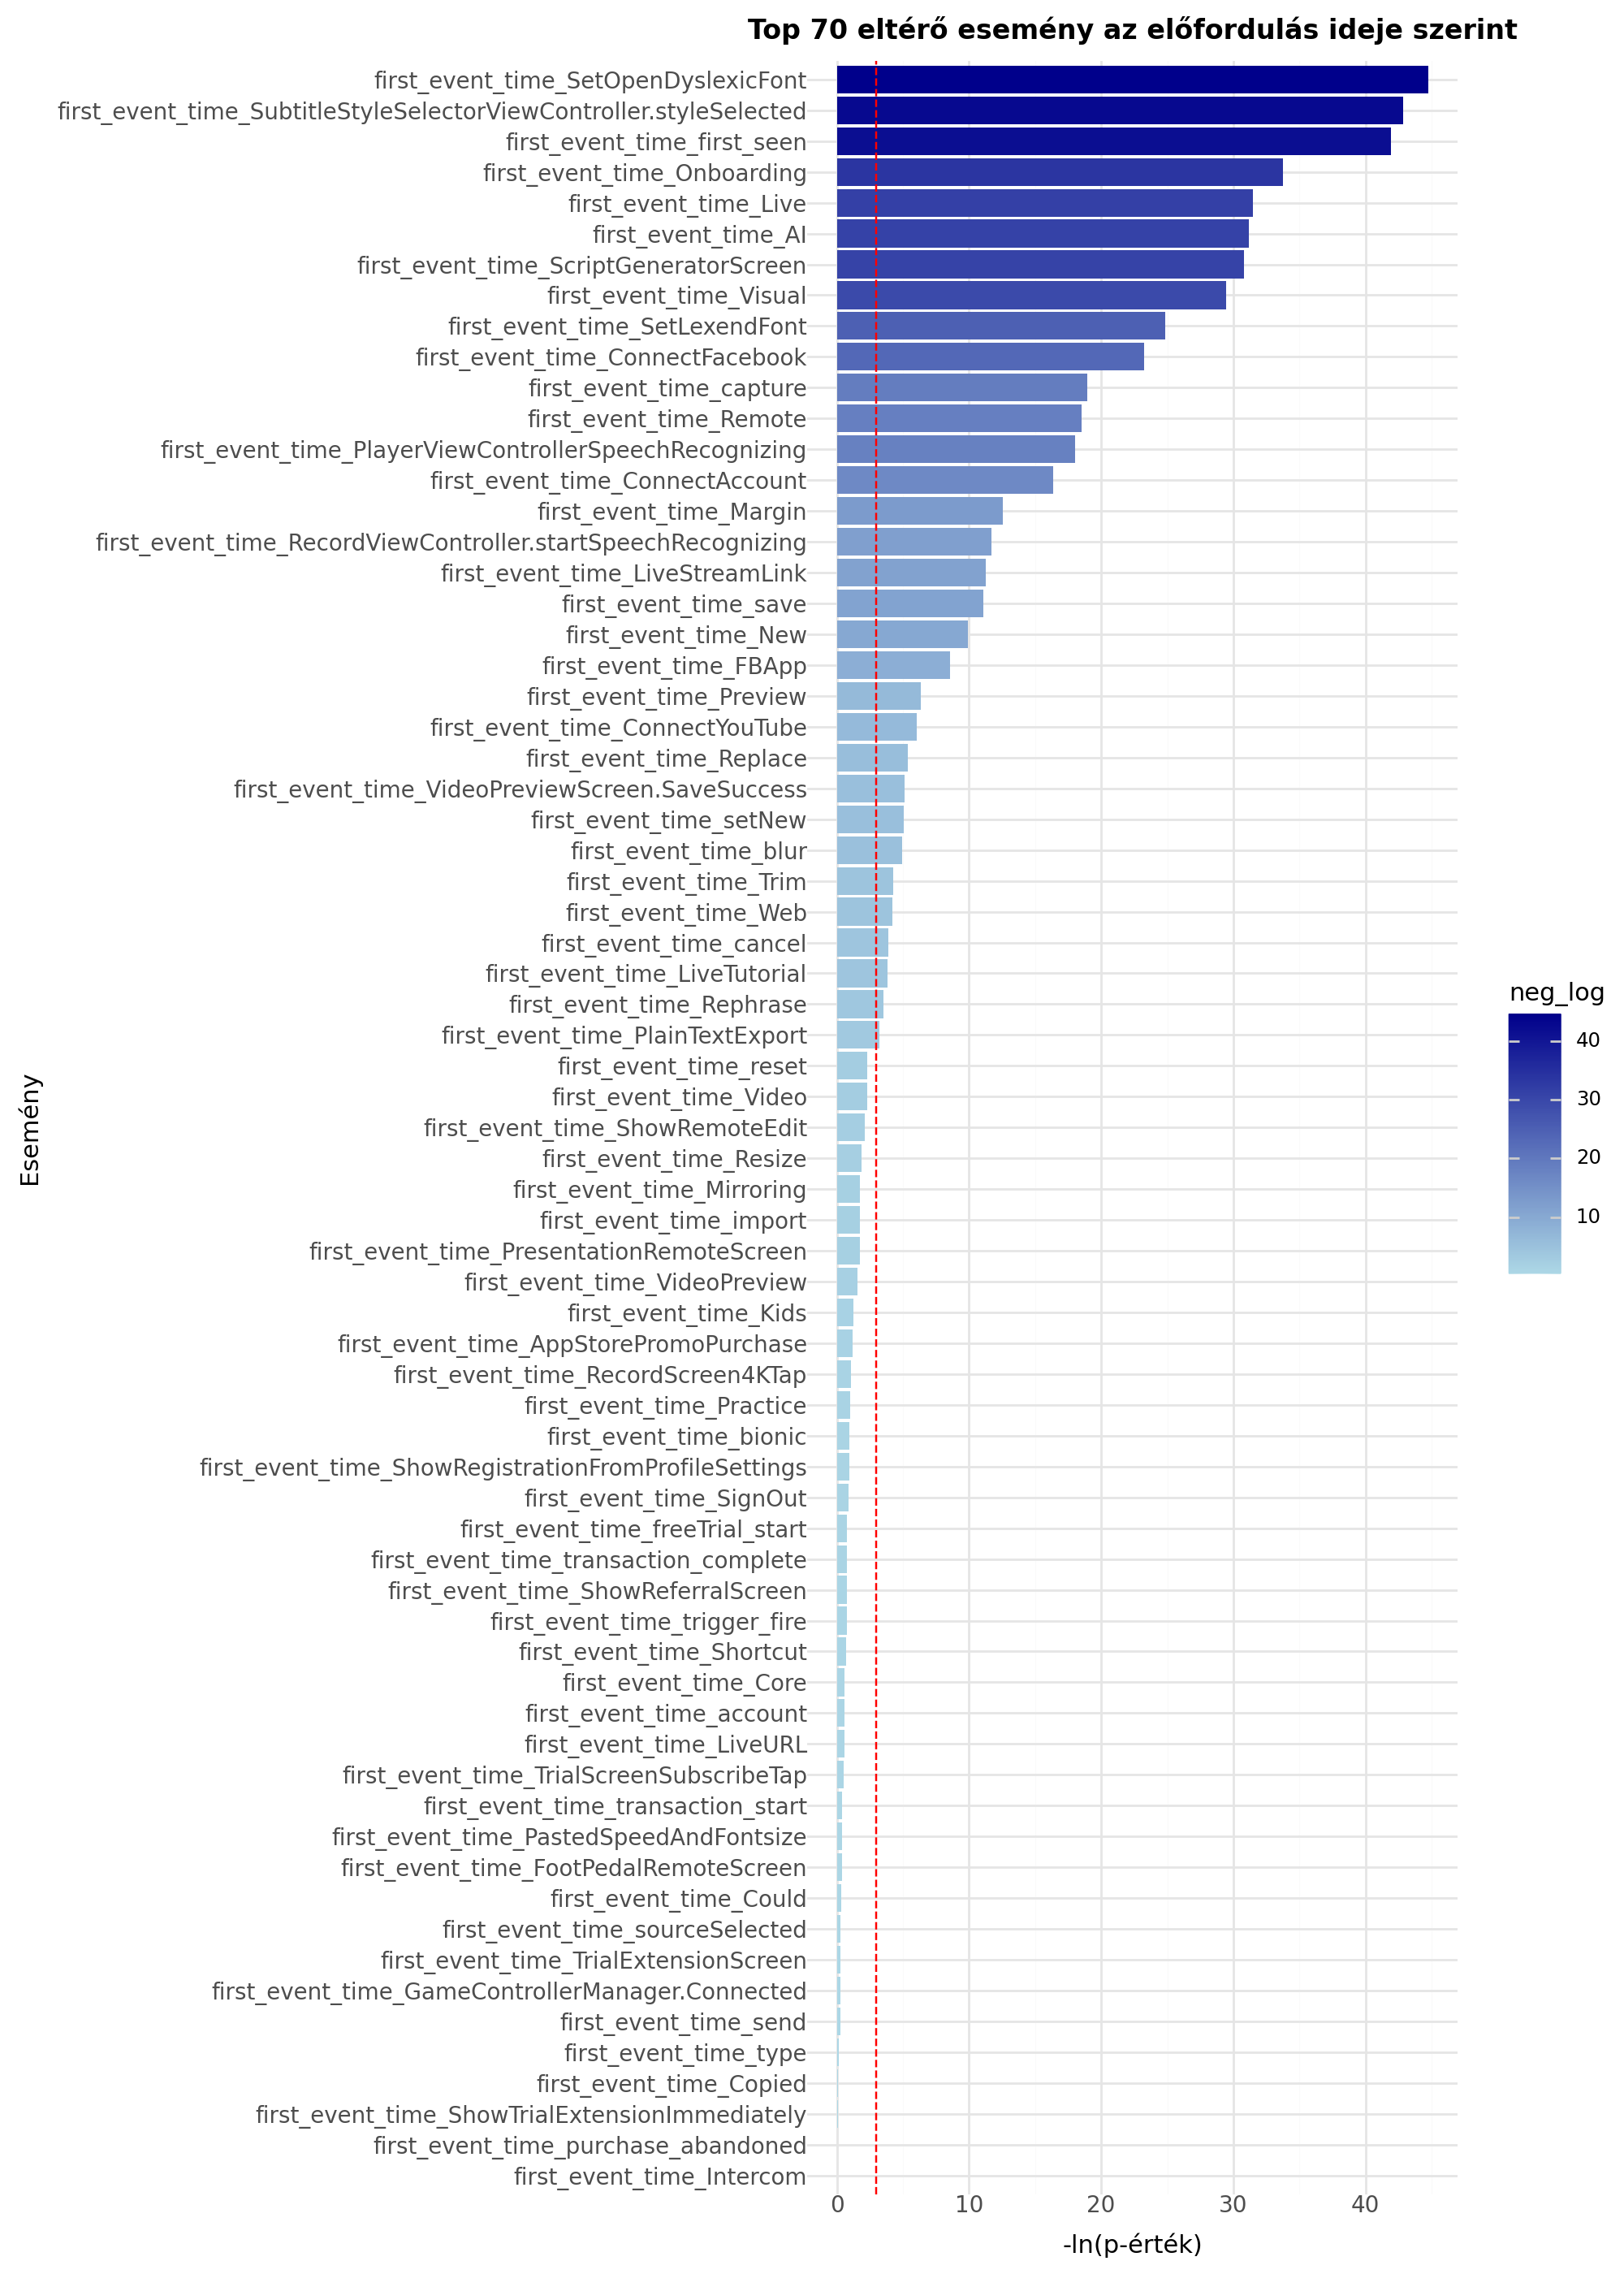

In [23]:
# Plotnine grafikon
#filtered_first_event_time = filtered_first_event_time[~filtered_first_event_time["event group"].isin(minor_event_to_drop)]
filtered_first_event_time_top70 = (
    ggplot(filtered_first_event_time.head(70), aes(x="event group", y="neg_log", fill="neg_log"))
    + geom_col()
    + coord_flip()
    + labs(
        title="Top 70 eltérő esemény az előfordulás ideje szerint",
        x="Esemény",
        y="-ln(p-érték)"
    )
    + geom_hline(yintercept=3, linetype="dashed", color="red")
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + theme_minimal()
    + theme(
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=10),
        plot_title=element_text(size=12, weight='bold'),
        figure_size=(10, 14)
    )
)

display(filtered_first_event_time_top70)

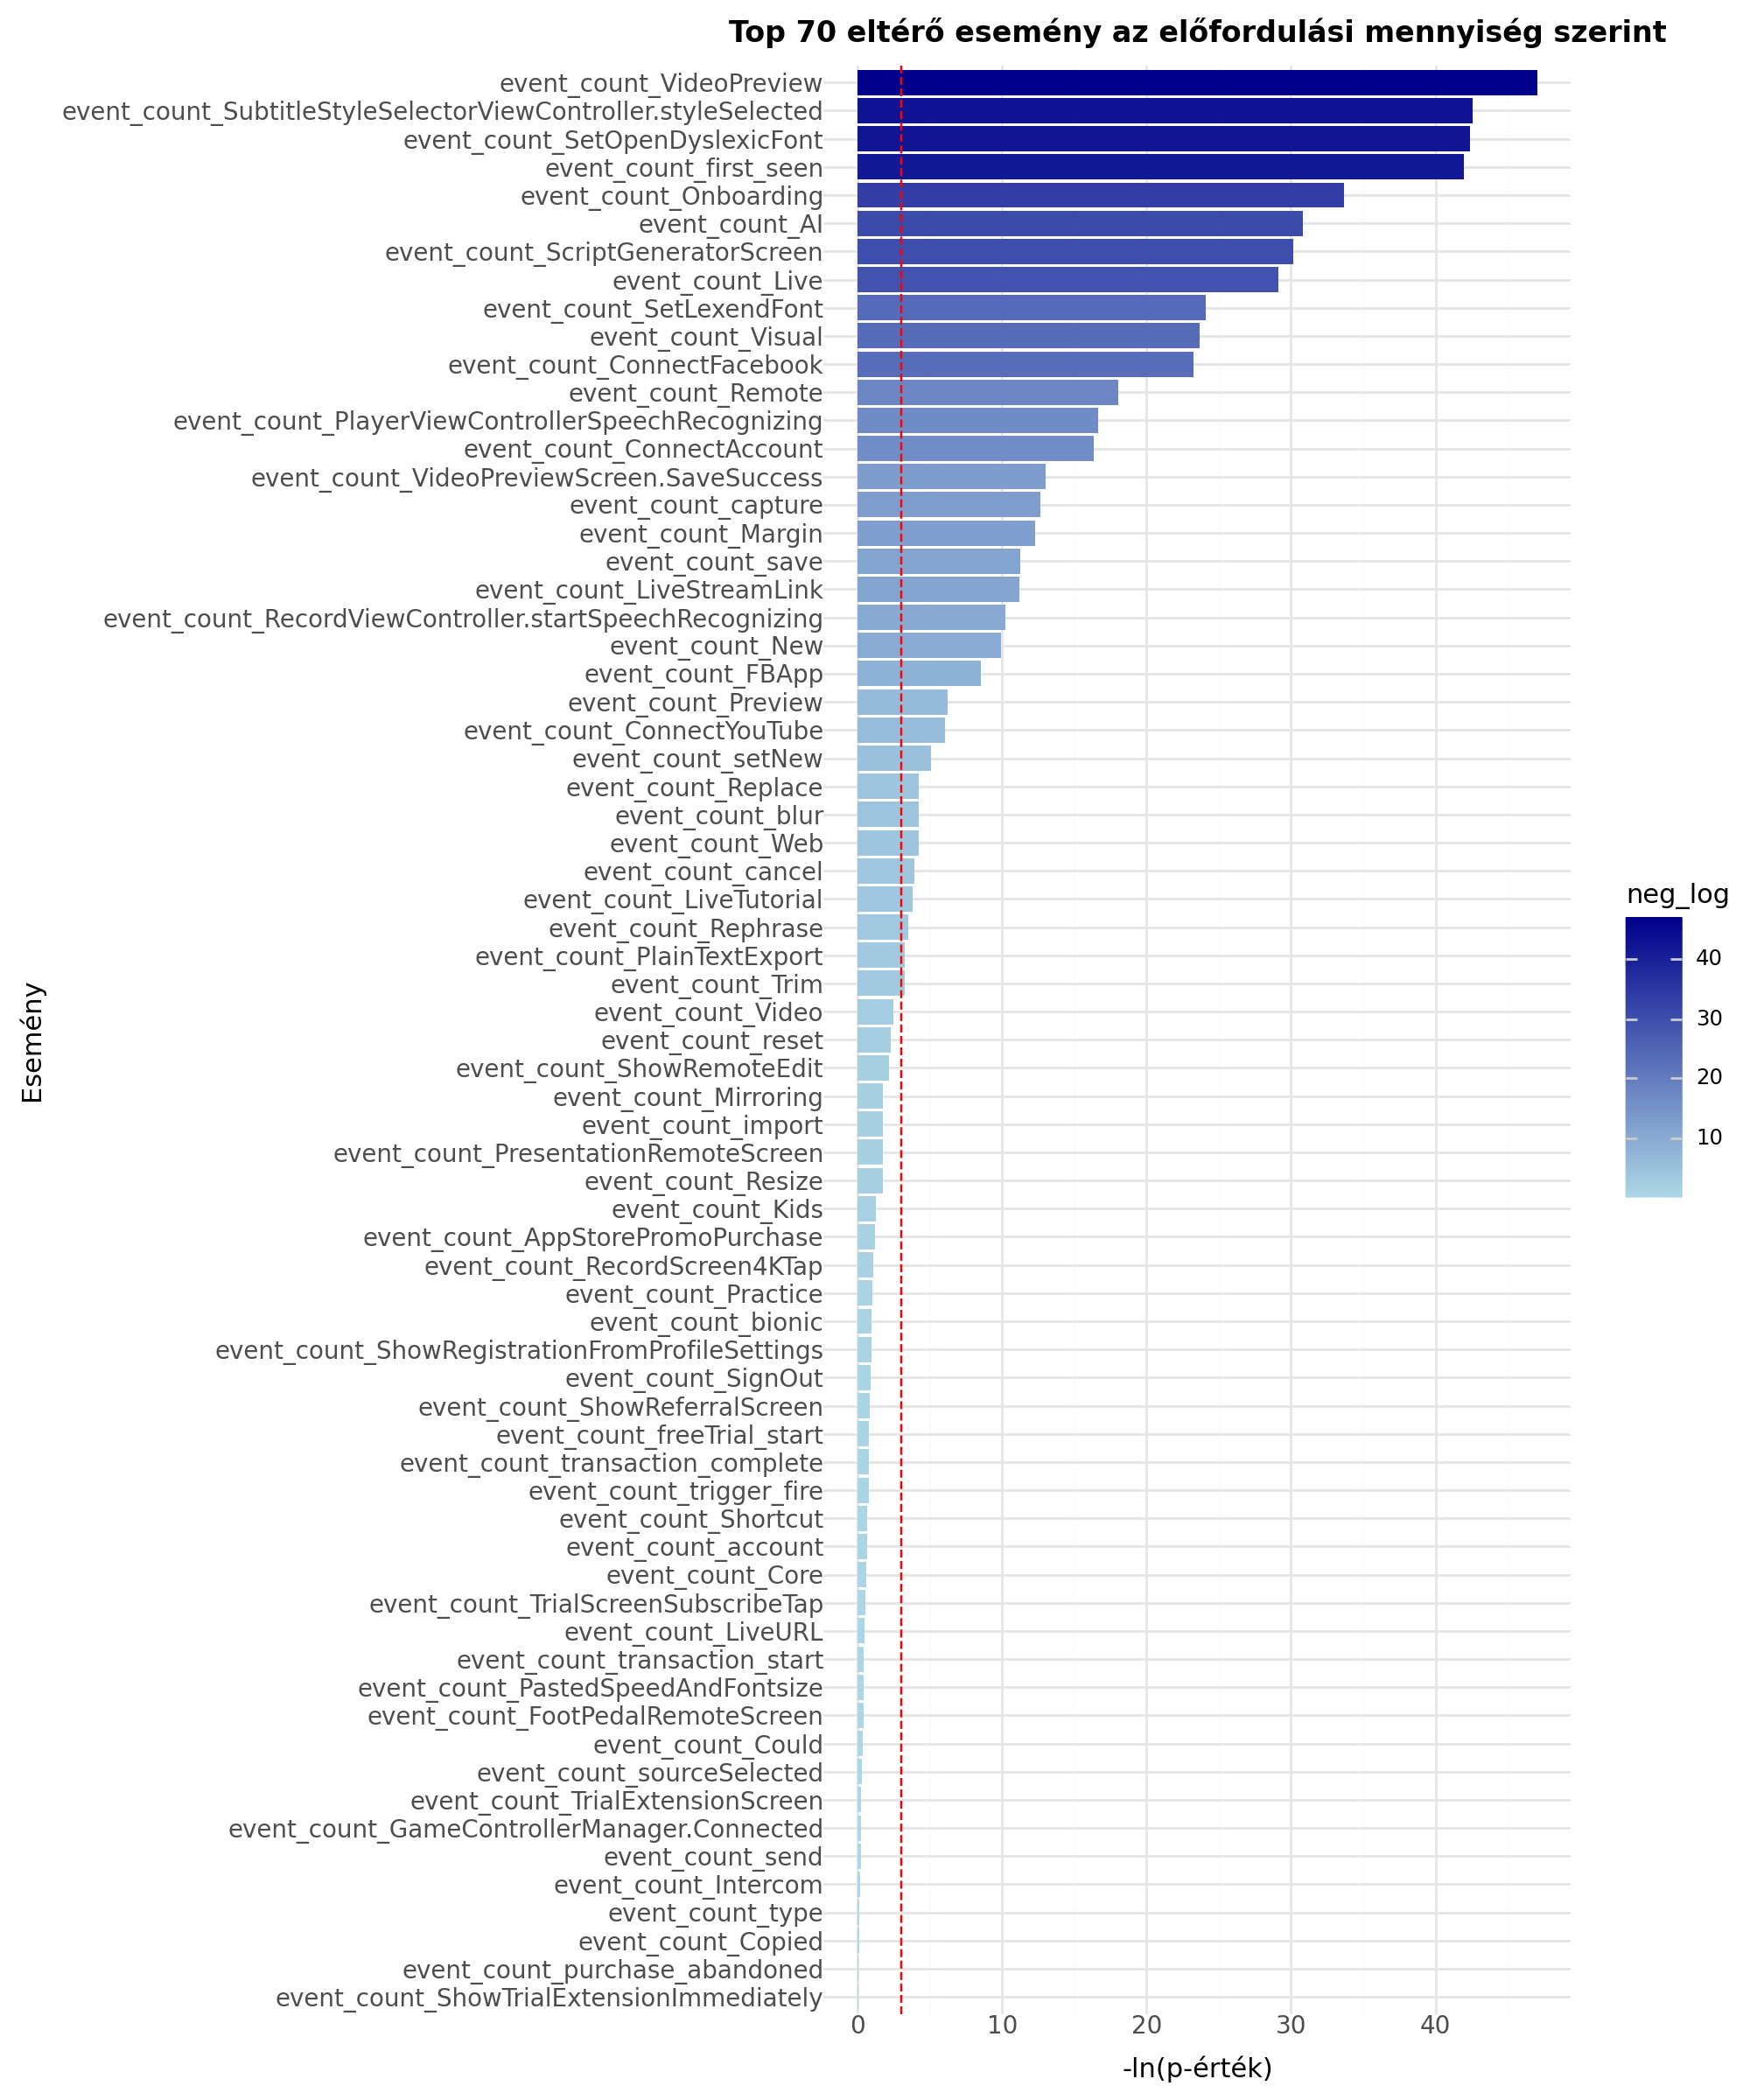

In [24]:
# Plotnine grafikon
filtered_event_count = filtered_event_count[~filtered_event_count["event group"].isin(minor_event_to_drop)]
filtered_event_count_top50 = (
    ggplot(filtered_event_count.head(70), aes(x="event group", y="neg_log", fill="neg_log"))
    + geom_col()
    + coord_flip()
    + labs(
        title="Top 70 eltérő esemény az előfordulási mennyiség szerint",
        x="Esemény",
        y="-ln(p-érték)"
    )
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + geom_hline(yintercept=3, linetype="dashed", color="red")
    + theme_minimal()
    + theme(
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=10),
        plot_title=element_text(size=12, weight='bold'),
        figure_size=(10, 12)
    )
)

display(filtered_event_count_top50)

### Levont következtetések:
A fenti ábrákon láthatóak a top 70 olyan esemény csoportok, amik szignifikánsan eltérnek egy előfizető és egy lemorzsolódott felhasználó eseményei között.
Az események kettő csoportba sorolhatóak: "first_event_time" kezdetűek -> az app elkezése utána hanyadik napon jelent meg az adott esemény először, míg az "event_count" kezdetűek pedig azt számolják, hogy az adott esemény csoport hányszor jelent meg az adott felhasználónál.
* A nagyobb érték nagyobb különbséget mutat az adatokban
* A statisztikailag legmarkánsabb különbség (user_attributes és session_start eventek) azzal kapcsolatosak, hogy a felhasználó használja az alkalmazást, azaz az adot esemény többször jelenik meg nála. 
* További markáns különbségek, hogy a későbbi előfizetők sokkal hamarabb elkezdik használni az alkalmazás funkcióit.

Sok esemény nem hordoz információt a felhasználó viselkedéséről, csak számolódik, ha használja az alkalmazást. Ezeket az eseményeket kiszűrtem a "minor_event_to_drop" listával.

Megfigyelés, hogy az adott esemény időben első használata (minél hamarabb) és használat száma együtt mozog.
További megfigyelés, hogy a felhasználóknál nem látható statisztikai különbség az alkalmazás fő funkcióinak használatában. Ebből arra következtetek, hogy nem minőségi problémájuk volt az alkalmazással.

A legnagyobb különbség az előfizető és elhagyó felhasználók között a billing_issue_event, ami lehet technikai problémára utal.

Néhány pozitív különbség, amit az előfizetők használtak:
* Dyslexic font
* Felirat stílusok
* AI
* Facebook kapcsolat

Néhány olyan funkció, amiben nem tértek el a felhasználók:
* 4k felvétel
* Trial extension (leendő előfizetők is spórolnak?)
* Remote funkciók
* Mirroring




## 5.3 A hét napjai szerinti elemzés

In [25]:
trial_events_for_analysis = ["trial_cancelled_event",
              "trial_converted_event","trial_started_event"
              ]
napok = ["hétfő", "kedd", "szerda", "csütörtök", "péntek", "szombat", "vasárnap"]
df_trial_days = full_filtered_df.filter(pl.col("event").is_in(trial_events_for_analysis)).with_columns([
    pl.col("date").dt.weekday().map_elements(lambda i: napok[i-1]).alias("nap")
])
df_trial_days_agg = df_trial_days.group_by(["nap", "event"]).len().sort(["nap", "event"])
df_trial_days_agg_sorted = df_trial_days_agg.collect().to_pandas()
df_trial_days_agg_sorted["nap"] = pd.Categorical(df_trial_days_agg_sorted["nap"], categories=napok, ordered=True)

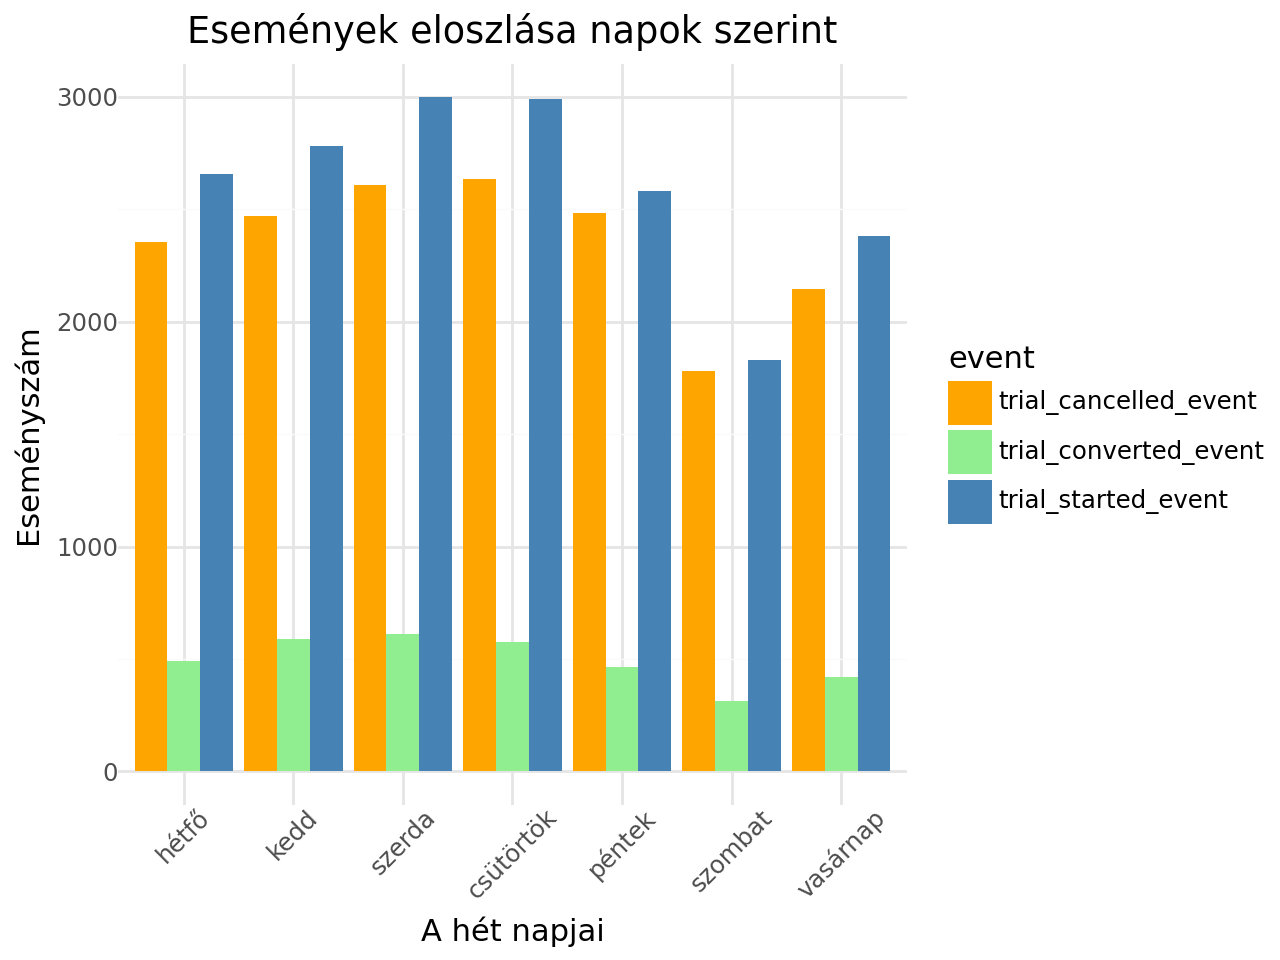

In [26]:
custom_colors = {
    "trial_started_event": "steelblue",     
    "trial_cancelled_event": "orange",   
    "trial_converted_event": "lightgreen"   
}

days_plot = (
    ggplot(df_trial_days_agg_sorted, aes(x="nap", y="len", fill="event"))
    + geom_col(position="dodge")  # stack/dodge?
    + labs(x="A hét napjai", y="Eseményszám", title="Események eloszlása napok szerint")
    + scale_fill_manual(values=custom_colors)
    + theme_minimal()
    + theme(axis_text_x=element_text(angle=45))
)
display(days_plot)
days_plot.save("./images/days_plot.png", dpi=300, transparent=True)

Következtetés
* A hét közepén kezdik el használni az alkalmazást többen, és kedd-csütörtök között várható legtöbb előfizetés.
  
Motiválhatóak a felhasználók, hogy melyik nap kezdjék el?
Optimalizálhatóak a közösségi média kampányok a hétfőre, keddre és szerdára?

## 5.4 USA és Indonézia különbségek vizsgálata
Hipotézis: nincs különbség az USA-ban élő és az Indonéziában élő, előfizető/lemondó felhasználók között.

In [27]:
aggregated_and_pivoted_users_df_with_transitions = aggregated_and_pivoted_users_df_with_transitions.lazy()

USA és Indonnesia felhasználók szétválasztása

In [28]:
usa_users = aggregated_and_pivoted_users_df_with_transitions.filter((pl.col("country_code") == 'US'))
indonesia_users = aggregated_and_pivoted_users_df_with_transitions.filter((pl.col("country_code") == 'ID'))

usa_users_converted = usa_users.filter(pl.col("transition") == 'trial_started_event -> trial_converted_event').collect()
usa_users_cancelled = usa_users.filter(pl.col("transition") == 'trial_started_event -> trial_cancelled_event').collect()
indonesia_users_converted = indonesia_users.filter(pl.col("transition") == 'trial_started_event -> trial_converted_event').collect()
indonesia_users_cancelled = indonesia_users.filter(pl.col("transition") == 'trial_started_event -> trial_cancelled_event').collect()


### Teszt az előfizető userekre:

In [29]:
results = MW_U_teszt_for_all_columns(usa_users_converted, indonesia_users_converted)

results_df = pl.DataFrame(results).transpose(include_header=True)
results_df.columns = ["event group", "p-value", "U-statistic"]
results_df = results_df.sort("p-value")

results_df2 = results_df.with_columns([
    ((pl.col("p-value").log())*(-1)).alias("neg_log")
]).sort("neg_log", descending=True).to_pandas()
results_df2["event group"] = pd.Categorical(results_df2["event group"], categories=results_df2["event group"].unique()[::-1].tolist(), ordered=True)

US_vs_ID_first_event_time = results_df2[results_df2["event group"].str.startswith("first_event_time")]
US_vs_ID_converted_count = results_df2[results_df2["event group"].str.startswith("event_count")]
results_df2.head(10)

,event group,p-value,U-statistic,neg_log
0,first_event_time_ShowReferralScreen,0.000094,9609.0,9.268544
1,event_count_ShowReferralScreen,0.000109,9618.0,9.126999
2,event_count_save,0.016920,10139.0,4.079235
3,first_event_time_save,0.017374,10141.0,4.052789
4,first_event_time_SetLexendFont,0.044696,9236.0,3.107874
5,event_count_SetLexendFont,0.065963,9353.5,2.718664
6,event_count_VideoPreview,0.068478,8048.5,2.681239
7,event_count_RecordViewController.startSpeechRe...,0.079748,8977.0,2.528882
8,first_event_time_VideoPreview,0.080094,8149.5,2.524557
9,first_event_time_RecordViewController.startSpe...,0.093121,9044.5,2.373853


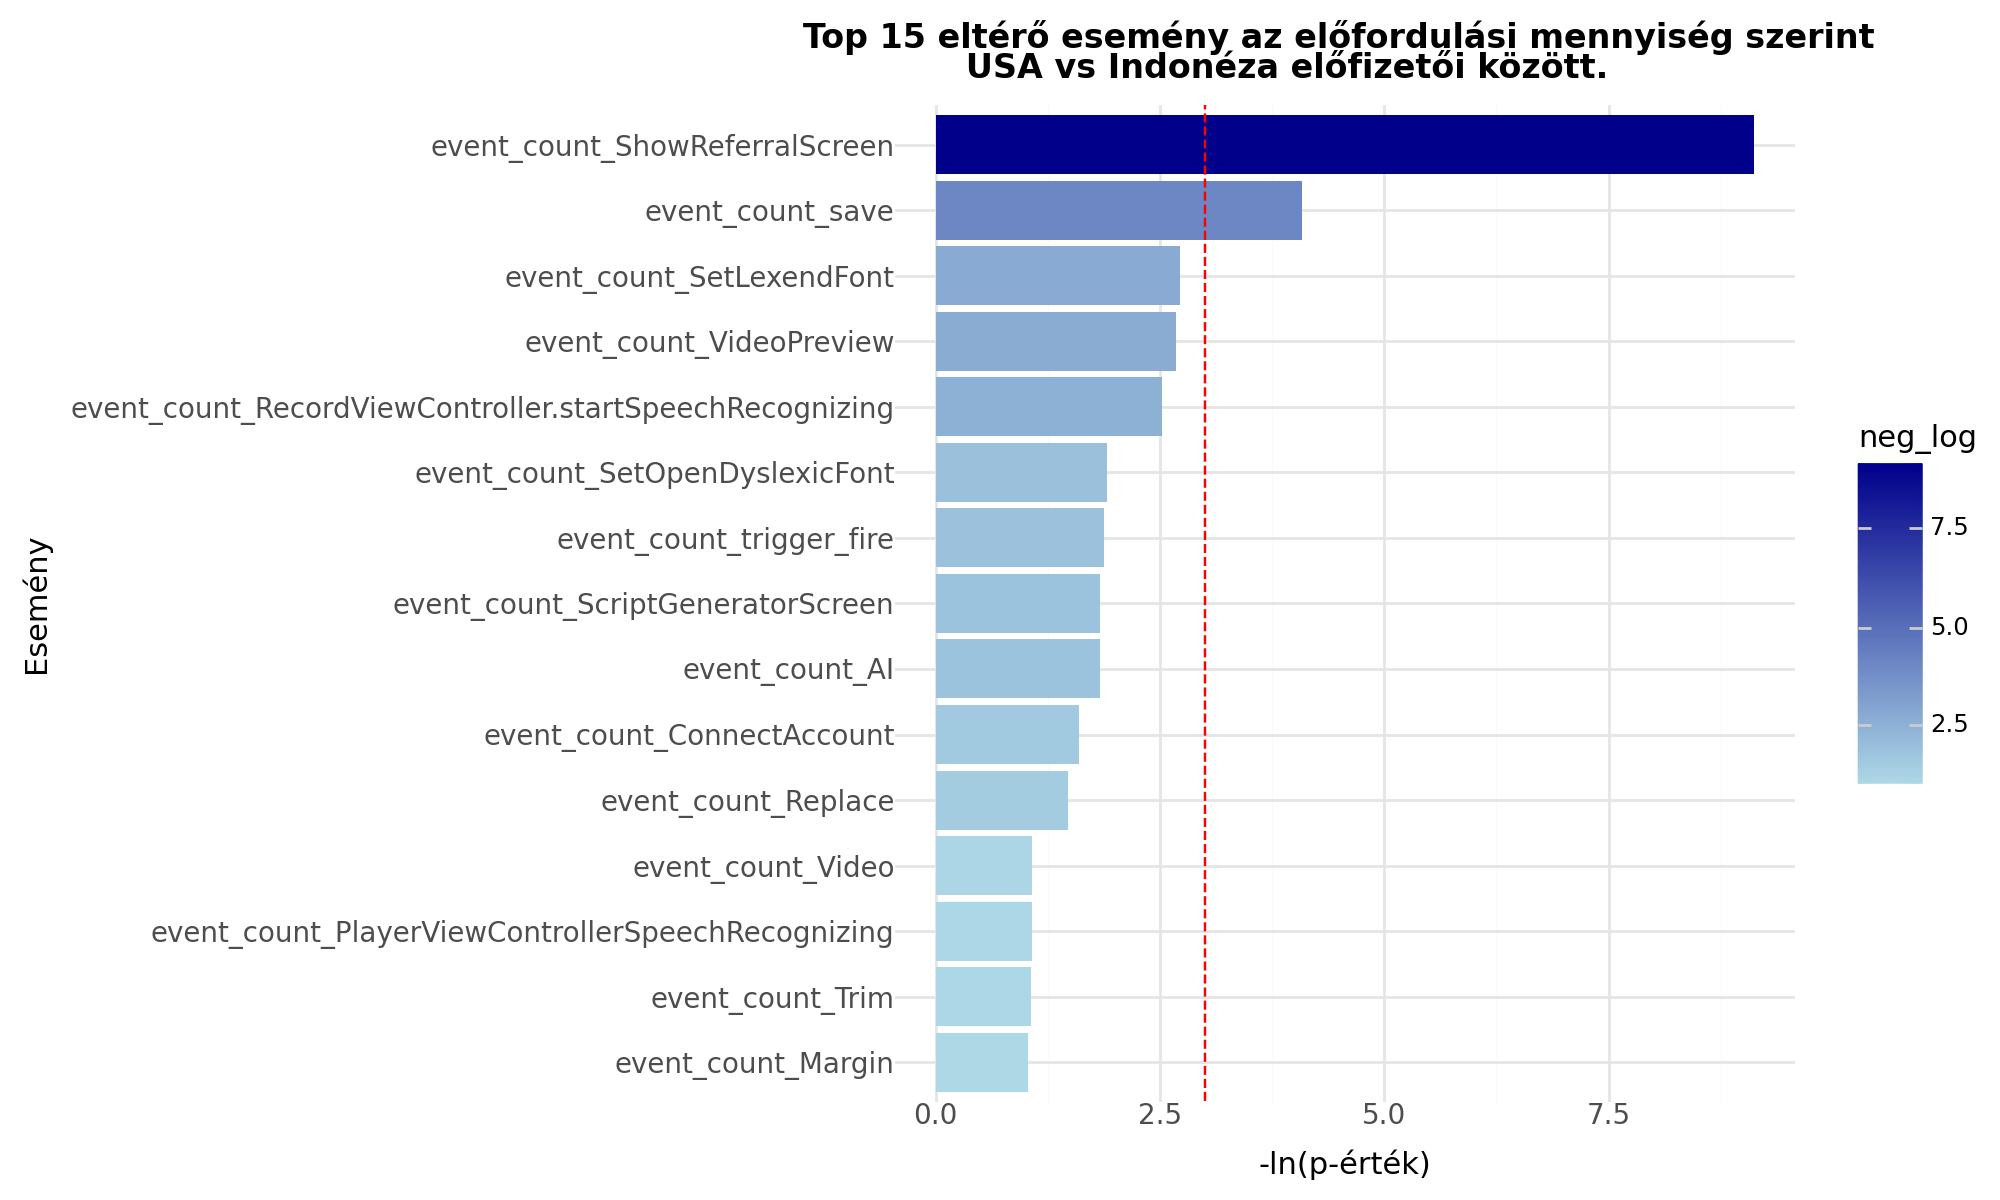

In [30]:
# Plotnine grafikon USA vs Indonezia
US_vs_ID_converted_count_top50 = (
    ggplot(US_vs_ID_converted_count.head(15), aes(x="event group", y="neg_log", fill="neg_log"))
    + geom_col()
    + coord_flip()
    + labs(
        title="Top 15 eltérő esemény az előfordulási mennyiség szerint \n              USA vs Indonéza előfizetői között.",
        x="Esemény",
        y="-ln(p-érték)"
    )
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + geom_hline(yintercept=3, linetype="dashed", color="red")
    + theme_minimal()
    + theme(
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=10),
        plot_title=element_text(size=12, weight='bold'),
        figure_size=(10, 6)
    )
)

display(US_vs_ID_converted_count_top50)
US_vs_ID_converted_count_top50.save("./images/US_vs_ID_converted_count_top50.png", dpi=300, transparent=True)

Eredmény: az előfizetők között gyakorlatilag nem mutatható ki éles különbség.

### Teszt a lemondó felhasználókra

In [31]:
results = MW_U_teszt_for_all_columns(usa_users_cancelled, indonesia_users_cancelled)

results_df = pl.DataFrame(results).transpose(include_header=True)
results_df.columns = ["event group", "p-value", "U-statistic"]
results_df = results_df.sort("p-value")

results_df2 = results_df.with_columns([
    ((pl.col("p-value").log())*(-1)).alias("neg_log")
]).sort("neg_log", descending=True).to_pandas()
results_df2["event group"] = pd.Categorical(results_df2["event group"], categories=results_df2["event group"].unique()[::-1].tolist(), ordered=True)

US_vs_ID_first_event_time = results_df2[results_df2["event group"].str.startswith("first_event_time")]
US_vs_ID_cancelled_count = results_df2[results_df2["event group"].str.startswith("event_count")]
results_df2.head(74)

,event group,p-value,U-statistic,neg_log
0,first_event_time_VideoPreview,2.273986e-68,2326945.0,155.754252
1,first_event_time_VideoPreviewScreen.SaveSuccess,1.252136e-49,2471282.5,112.601819
2,event_count_VideoPreviewScreen.SaveSuccess,2.822110e-45,2526390.5,102.578845
3,event_count_VideoPreview,5.255376e-24,2715376.0,53.602791
4,event_count_save,5.871431e-20,3090922.5,44.281603
5,first_event_time_save,7.633334e-20,3091401.5,44.019177
6,event_count_Video,2.498403e-16,3093473.5,35.925710
7,first_event_time_Video,4.320763e-16,3094692.0,35.377930
8,event_count_AI,7.657017e-13,3395669.0,27.897984
9,first_event_time_AI,3.569801e-12,3391239.0,26.358511


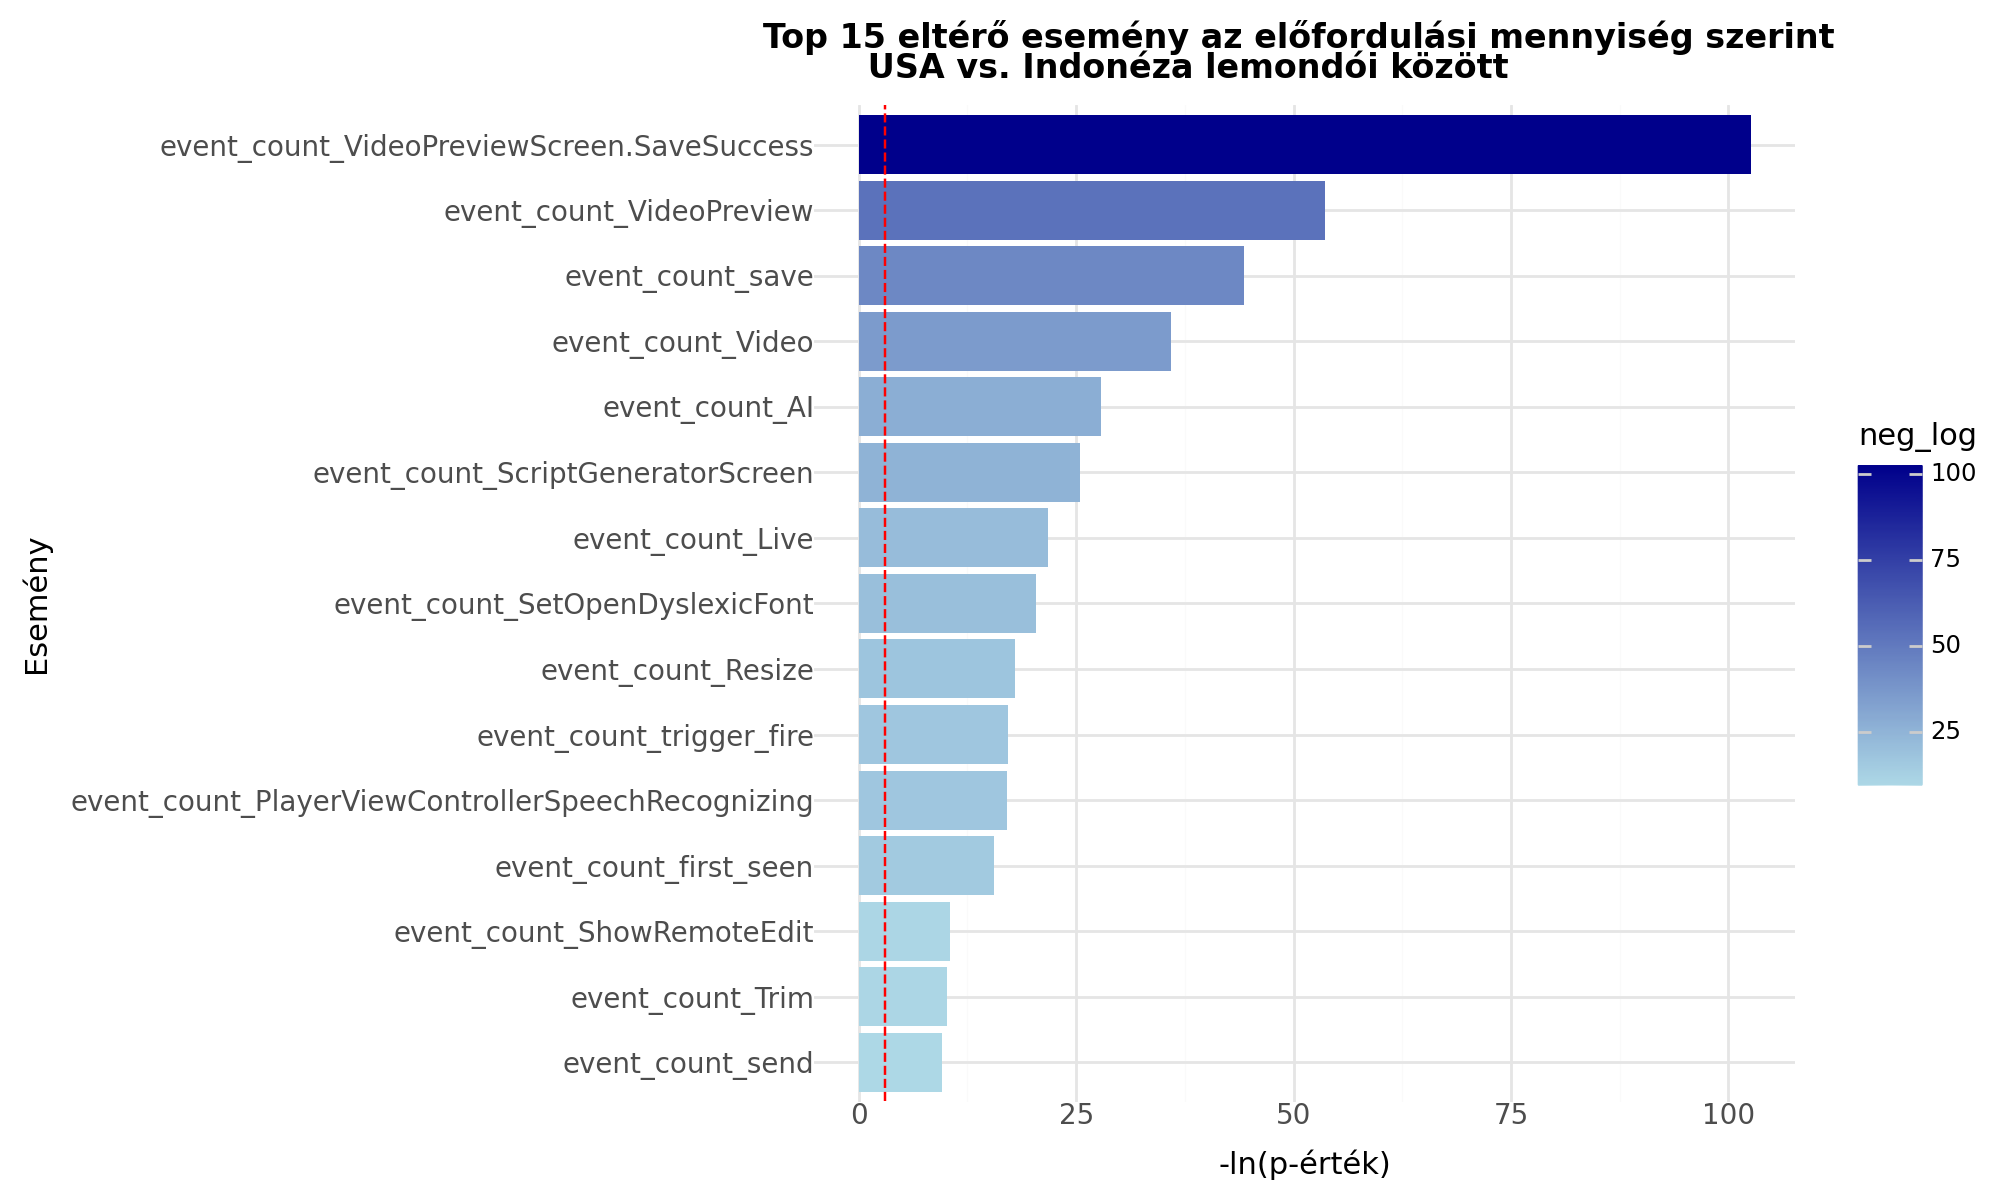

In [32]:
# Plotnine grafikon USA vs Indonezia cancelled userre
US_vs_ID_cancelled_event_count_top50 = (
    ggplot(US_vs_ID_cancelled_count.head(15), aes(x="event group", y="neg_log", fill="neg_log"))
    + geom_col()
    + coord_flip()
    + labs(
        title="Top 15 eltérő esemény az előfordulási mennyiség szerint \n         USA vs. Indonéza lemondói között",
        x="Esemény",
        y="-ln(p-érték)"
    )
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + geom_hline(yintercept=3, linetype="dashed", color="red")
    + theme_minimal()
    + theme(
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=10),
        plot_title=element_text(size=12, weight='bold'),
        figure_size=(10, 6)
    )
)

display(US_vs_ID_cancelled_event_count_top50)
US_vs_ID_cancelled_event_count_top50.save("./images/US_vs_ID_cancelled_event_count_top50.png", dpi=300, transparent=True)

Itt viszont megfigyelhető, ha összevetjük az USA-ban és Indonéziában élő, nem előfizető felhasználókat, hogy bizony olyan az alkalmazás használatában nagy különbség van. Elsősorban azoknál az eseményeknél, amik az alkalmazás "normál" használata során, pl videó felvevése során, jönnek létre.
Ez megmagyarázza a terület alapú elemzés során feltárt eredményeket, miszert habár tetszik a felhasználóknak az alkalmazás, nem szeretnék/tudják megvásárolni az ára miatt.

A felhasználók visszeélnek a GDPR miatt adattörléssel, és egyszerűen újraindítják a próbaidőszakot, tudva, hogy nem fognak előfizetni.

Javaslat:
* árcsökkentés
* Mivel a GDPR Indonéziában nem érvényes, Apple ID/device ID alapú szűrés, hogy ne lehessen többször trialt indítani uótöbbször egymás után